In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import numpy.random as ra
import pandas as pd
import seaborn as sns
import scipy.constants as sc
from scipy import signal

import HERA_hack_FG
import FG_pygsm
%load_ext autoreload
%autoreload 2


# Unresolved Point Source

Here we are generating average fluxes in each pixel due to a fixed number of sources per pixel. We do this using two pieces of information: 
1. Distribution of spectral indices of the sources
2. Source Count distribution

The method is the following: 
1. Draw n_sources number of spectral indices from a gaussian distribution
2. Draw n_soucres number of fiducial fluxes from the CDF of the source count distribution using **inverse transform sampling**. 
3. Compute the fluxes of each source and average over them.
4. Repeat for npix.

Text(0, 0.5, 'dn/d$S_*$')

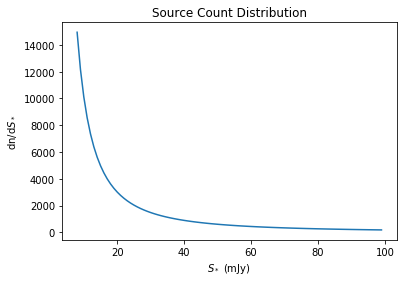

In [2]:
#differential source count 
gamma = 1.75

def dnds(s):
    return 4.*(s/880)**(-gamma)

s = np.arange(8,100,1)


#plt.loglog(s,dnds(s))
pdf = np.asarray([s,dnds(s)]) #0 is s, 1 is dnds

plt.plot(pdf[0],pdf[1])
plt.title('Source Count Distribution')
plt.xlabel('$S_*$ (mJy)')
plt.ylabel('dn/d$S_*$')

Text(0, 0.5, 'Probability')

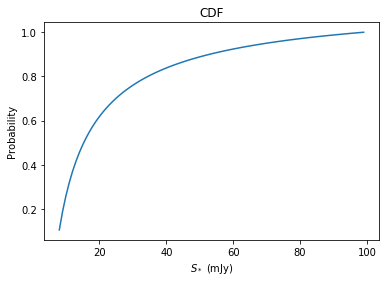

In [3]:
prob = pdf[1]/float(sum(pdf[1]))
cum_prob = np.cumsum(prob)
plt.plot(s,cum_prob)
plt.title('CDF')
plt.xlabel('$S_*$ (mJy)')
plt.ylabel('Probability')

Text(0, 0.5, 'dn/d$S_*$')

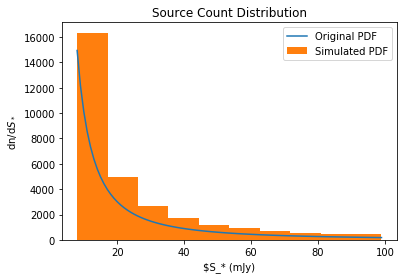

In [4]:

def gen_fluxes(N):
    R = ra.uniform(0, 1, N)
    #Here we first find the bin interval that random number lies in min(cum_prob[])
    #then we find the flux who's index is that cum_prob
    #repat for all r in R
    return [int(s[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]

N = 30000

plt.plot(pdf[0],pdf[1], label = 'Original PDF')
plt.hist(gen_fluxes(N), label = 'Simulated PDF')
plt.legend()
plt.title('Source Count Distribution')
plt.xlabel('$S_* (mJy)')
plt.ylabel('dn/d$S_*$')

In [5]:
dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])
HERA = HERA_hack.telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')

obs = HERA_hack.observation(HERA, 100, 100, 0.01,acorner,1, 0.2, norm = False, pbeam = False)


#number of pixels in the map
npix =len(obs.observable_coordinates())



#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta




In [6]:
obs.Npix

1500

In [7]:
#integral over d_omega
theta_res = np.abs(np.cos(obs.observable_coordinates()[1,0])-np.cos(obs.observable_coordinates()[0,0]))
phi_res = obs.observable_coordinates()[30,1]- obs.observable_coordinates()[1,1]
omega_pix = theta_res*phi_res
##ADD COS THETAS int(cos(theta) dtheta dphi)! 
omega_pix

1.0846967597107002e-05

In [8]:
n_sources = 10
alpha_0 = 2.5
sigma = 0.5
freq = 100 #inherited
fiducial_freq = 150

pixel_flux = []

for i in range(npix):
    alpha = np.random.normal(alpha_0,sigma,n_sources)
    S_star = gen_fluxes(n_sources)
    sum_fluxes = 0 

    for i in range(n_sources-1):
        factor = 1.4e-6*((freq/fiducial_freq)**(-2))*(omega_pix**(-1))
        sum_fluxes += factor*S_star[i]*(freq/fiducial_freq)**(-alpha[i])
    
    pixel_flux.append(sum_fluxes/n_sources)



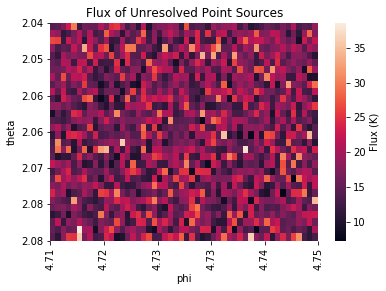

In [285]:

df_obs = pd.DataFrame.from_dict(np.array([x,y,pixel_flux]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Flux of Unresolved Point Sources', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# Galactic Synchrotron

For Galactic Synchrotron emission, we can create our field in a similar fashion to the unresolved point sources, except our Gaussian has mean spectral index $\alpha_{syn} = 2.8$ and standard deviation $\sigma_{syn} = 0.1$. We compute the flux in each pixel with a different randomly sampled $\alpha$ (Wang et al. 2006).

In [9]:

alpha_0_syn = 2.8
sigma_syn = 0.1
freq = 100 #inherited MHz
fiducial_freq = 150 #MHz
Asyn = 335.4 #K

pixel_flux_syn = []

alpha_syn = np.random.normal(alpha_0_syn,sigma_syn,npix)


for i in range(npix):
    flux = Asyn*(freq/fiducial_freq)**(-alpha_syn[i])
    pixel_flux_syn.append(flux)




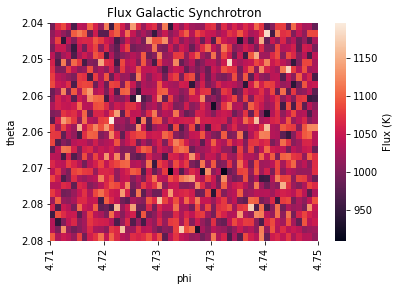

In [231]:
df_obs = pd.DataFrame.from_dict(np.array([x,y,pixel_flux_syn]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Flux Galactic Synchrotron', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# Free-Free Emission 

 For Galactic Synchrotron emission, we can create our field in a similar fashion to the unresolved point sources, except our Gaussian has mean spectral index $\alpha_{ff} = 2.15$ and standard deviation $\sigma_{ff} = 0.01$. We compute the flux in each pixel with a different randomly sampled $\alpha$ (Wang et al. 2006).

In [10]:

alpha_0_ff = 2.15
sigma_ff = 0.01
freq = 100 #inherited MHz
fiducial_freq = 150 #MHz
Aff = 33.5 #K

pixel_flux_ff = []

alpha_ff = np.random.normal(alpha_0_ff,sigma_ff,npix)


for i in range(npix):
    flux = Aff*(freq/fiducial_freq)**(-alpha_ff[i])
    pixel_flux_ff.append(flux)





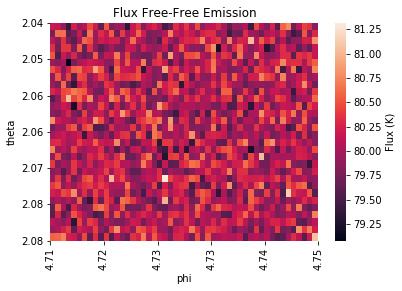

In [233]:
df_obs = pd.DataFrame.from_dict(np.array([x,y,pixel_flux_ff]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Flux Free-Free Emission', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# Total Foreground Flux

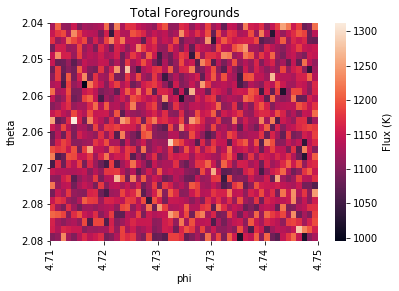

In [15]:
pixel_flux = np.asarray(pixel_flux)
pixel_flux_ff = np.asarray(pixel_flux_ff)
pixel_flux_syn = np.asarray(pixel_flux_syn)

total_fg = pixel_flux + pixel_flux_ff + pixel_flux_syn

df_obs = pd.DataFrame.from_dict(np.array([x,y,total_fg]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Total Foregrounds', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

In [287]:
np.savetxt('total_foregrounds.txt',total_fg)

In [16]:
freq_fid = 150
def generate_foregrounds():
############ SYNCHRO EMISSION ############

    alpha_0_syn = 2.8
    sigma_syn = 0.1
    Asyn = 335.4 #K

    pixel_flux_syn = []

    alpha_syn = np.random.normal(alpha_0_syn,sigma_syn,obs.Npix)

    for i in range(obs.Npix):
        flux = Asyn*(obs.freq/freq_fid)**(-alpha_syn[i])
        pixel_flux_syn.append(flux)




    ########### FREE FREE EMISSION ##########

    alpha_0_ff = 2.15
    sigma_ff = 0.01
    Aff = 33.5 #K

    pixel_flux_ff = []

    alpha_ff = np.random.normal(alpha_0_ff,sigma_ff,obs.Npix)

    for i in range(obs.Npix):
        flux = Aff*(obs.freq/freq_fid)**(-alpha_ff[i])
        pixel_flux_ff.append(flux)

    ########### UNRES POINT SOURCE ###########

    gamma = 1.75

    def dnds(s):
        return 4.*(s/880)**(-gamma)

    s = np.arange(8,100,1) #maybe make this an argument 

    pdf = np.asarray([s,dnds(s)]) #0 is s, 1 is dnds
    prob = pdf[1]/float(sum(pdf[1]))
    cum_prob = np.cumsum(prob)

    def gen_fluxes(N):
        R = ra.uniform(0, 1, N)
        #Here we first find the bin interval that random number lies in min(cum_prob[])
        #then we find the flux who's index is that cum_prob
        #repat for all r in R
        return [int(s[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]

    alpha_0 = 2.5
    sigma = 0.5

    theta_res = np.abs(np.cos(obs.observable_coordinates()[1,0])-np.cos(obs.observable_coordinates()[0,0]))
    phi_res = obs.observable_coordinates()[30,1]- obs.observable_coordinates()[1,1]
    omega_pix = theta_res*phi_res
    factor = 1.4e-6*((obs.freq/freq_fid)**(-2))*(omega_pix**(-1))

    pixel_flux = []

    for i in range(obs.Npix):
        alpha = np.random.normal(alpha_0,sigma,n_sources)
        S_star = gen_fluxes(n_sources)
        sum_fluxes = 0 

        for i in range(n_sources-1):
            sum_fluxes += factor*S_star[i]*(obs.freq/freq_fid)**(-alpha[i])

        pixel_flux.append(sum_fluxes/n_sources)


    ########## TOTAL FG ################

    pixel_flux = np.asarray(pixel_flux)
    pixel_flux_ff = np.asarray(pixel_flux_ff)
    pixel_flux_syn = np.asarray(pixel_flux_syn)
    
    total_fg = pixel_flux + pixel_flux_ff + pixel_flux_syn

    return total_fg

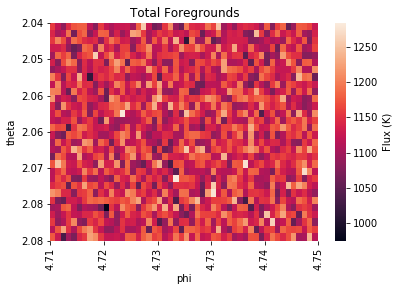

In [23]:
df = pd.DataFrame.from_dict(np.array([x,y,generate_foregrounds()]).T)
df.columns = ['phi','theta','temp']



pivotted_obs= df.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Total Foregrounds', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# IMPORTING

In [3]:
#SETUP 

freq_fid = 150

n_dim_sources = 100

dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

HERA = HERA_hack_FG.telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')

obs = HERA_hack_FG.observation(HERA, 100, 150, 0.01,acorner,1, 0.2, norm = True, pbeam = True)

fg = FG_pygsm.foregrounds(obs,150)

In [99]:
np.arange(0,100,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [98]:
fg.bright_psource(16)

[[1.255351   0.5298119  2.09439573]
 [0.347007   4.11382329 2.0943962 ]
 [0.538232   4.3163732  2.09439723]
 ...
 [5.768713   1.27735367 1.95514225]
 [6.863579   1.29230997 1.95458491]
 [7.997636   0.06719514 2.23537826]]
1.446590502384213e+23
[[1.81597883e+23 5.29811903e-01 2.09439573e+00]
 [5.01977030e+22 4.11382329e+00 2.09439620e+00]
 [7.78601299e+22 4.31637320e+00 2.09439723e+00]
 ...
 [8.34496544e+23 1.27735367e+00 1.95514225e+00]
 [9.92878819e+23 1.29230997e+00 1.95458491e+00]
 [1.15693043e+24 6.71951413e-02 2.23537826e+00]]


array([[1.81597883e+23, 5.29811903e-01, 2.09439573e+00],
       [5.01977030e+22, 4.11382329e+00, 2.09439620e+00],
       [7.78601299e+22, 4.31637320e+00, 2.09439723e+00],
       ...,
       [8.34496544e+23, 1.27735367e+00, 1.95514225e+00],
       [9.92878819e+23, 1.29230997e+00, 1.95458491e+00],
       [1.15693043e+24, 6.71951413e-02, 2.23537826e+00]])

In [4]:
#imp =  100000*signal.unit_impulse(fg.Npix, mid_pixel) #True sky we wanna see


#number of pixels in the map
npix =len(obs.observable_coordinates())



#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta

mid_pixel = np.int(fg.Npix*0.5098507)

diffuse_fg = fg.diffuse_fg(n_dim_sources,pygsm = False)
imp_multi = (signal.unit_impulse(npix,0)+  signal.unit_impulse(npix, mid_pixel)+signal.unit_impulse(npix, 'mid') + signal.unit_impulse(npix, 1234) +signal.unit_impulse(npix,193)+signal.unit_impulse(npix, 687)+signal.unit_impulse(npix, 1432)+ signal.unit_impulse(npix, 122 )+signal.unit_impulse(npix, 13)+signal.unit_impulse(npix, 1344)+signal.unit_impulse(npix, 45))
true_sky = imp_multi+diffuse_fg
# foregrounds = fg.diffuse_fg(n_dim_sources,16) #diffuse fg 
# psource_data = fg.bright_psource(16)

print(imp_multi)

print(true_sky)

[1. 0. 0. ... 0. 0. 0.]
[372.67367842 371.85953682 371.63366724 ... 372.23383498 371.58333059
 371.99634925]


In [5]:
sky = obs.convolve_map(imp_multi,None)




In [103]:
single_pix_map = np.zeros(npix)

for i in range(npix):
    single_pix_map[i] = obs.single_pix_convolve_map(i,imp_multi,None)

/Users/hannahfronenberg/anaconda2/envs/p37workshop/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [104]:
single_pix_map

array([ 1.82276127e-03,  2.21621793e-03,  2.43477249e-03, ...,
        1.48024636e-04,  2.94497647e-05, -2.58765914e-05])

In [53]:
#psource_data = fg.bright_psource('data_file.txt') #eventually this will be input in convolve map

mid_pixel = np.int(fg.Npix*0.5098507)

psource_data = np.asarray([[5,-0.1, -0.89, -0.45]])
psource_data.shape

#MAPPING
sky_map_FG = np.real(obs.convolve_map(true_sky,None))

#sky_map =  np.real(obs.convolve_map(imp,None,None))


In [80]:
obs.compute_beam(psource_data)

1


ValueError: could not broadcast input array from shape (1500) into shape (1501)

        $\phi$  $\Theta$      temp
0     4.712389  2.042035  1.319224
1     4.712389  2.045526  1.239509
2     4.712389  2.049017  1.071186
3     4.712389  2.052507  0.844326
4     4.712389  2.055998  0.470644
...        ...       ...       ...
1495  4.883431  2.129302  0.318081
1496  4.883431  2.132792  0.243990
1497  4.883431  2.136283  0.247161
1498  4.883431  2.139774  0.061410
1499  4.883431  2.143264 -0.068595

[1500 rows x 3 columns]
(30, 50)


[Text(0, 0.5, '2.04'),
 Text(0, 2.5, '2.05'),
 Text(0, 4.5, '2.06'),
 Text(0, 6.5, '2.06'),
 Text(0, 8.5, '2.07'),
 Text(0, 10.5, '2.08'),
 Text(0, 12.5, '2.08')]

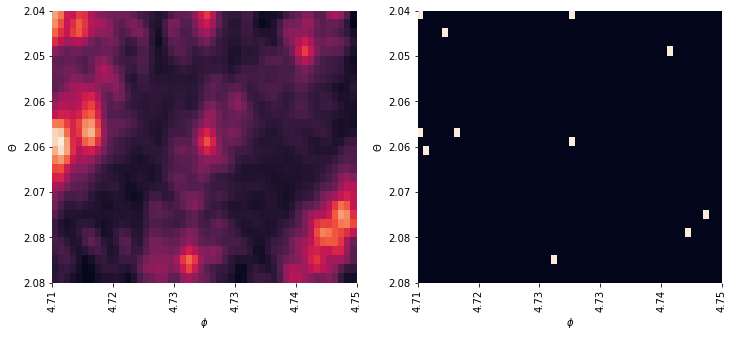

In [8]:
# #number of pixels in the map
# npix =len(obs.observable_coordinates())



# #making separate arrays of theta and phi for data vis
# x = np.zeros(npix)

# y = np.zeros_like(x)

# for i in range(len(obs.observable_coordinates())):
#     x[i]= obs.observable_coordinates()[i,1] #phi
#     y[i] = obs.observable_coordinates()[i,0]#theta




df_sky_fg = pd.DataFrame.from_dict(np.array([x,y,np.real(sky[:1500])]).T)
df_sky_fg.columns = ['$\phi$','$\Theta$','temp']
pivotted_obs_fg= df_sky_fg.pivot('$\Theta$','$\phi$','temp')

print(df_sky_fg)
print(pivotted_obs_fg.shape)

df_sky = pd.DataFrame.from_dict(np.asarray([x,y,imp_multi]).T)
df_sky.columns = ['$\phi$','$\Theta$','temp']
pivotted_sky= df_sky.pivot('$\phi$','$\Theta$','temp')
df_sky_transposed = pivotted_sky.transpose()



from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,2, figsize = (12,5))


sns.heatmap(pivotted_obs_fg,ax=ax[0],cbar = False)#cbar_kws={'label': 'Flux (K)'})
#im1 = ax[0].set_title('Interferometric Map', y = 1.04)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(6))
ax[0].yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax[0].get_xticklabels()]
ylabels = [item.get_text() for item in ax[0].get_yticklabels()]
ax[0].set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax[0].set_yticklabels([str(round(float(label), 2)) for label in ylabels])

sns.heatmap(df_sky_transposed,ax=ax[1],cbar = False)#cbar_kws={'label': 'Flux (K)'})
#im1 = ax[1].set_title('True Sky', y = 1.04)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(6))
ax[1].yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax[1].get_xticklabels()]
ylabels = [item.get_text() for item in ax[1].get_yticklabels()]
ax[1].set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax[1].set_yticklabels([str(round(float(label), 2)) for label in ylabels])




In [143]:
#something is weird, try working this out by hand because it may not introduce a bias actually. 

In [262]:
fg.bright_psource(16)

['GLEAM', 'RAJ2000', 'DEJ2000', 'Fpwide', 'Fintwide', 'eabsFpct', 'efitFpct', 'Fp076', 'Fint076', 'Fp084', 'Fint084', 'Fp092', 'Fint092', 'Fp099', 'Fint099', 'Fp107', 'Fint107', 'Fp115', 'Fint115', 'Fp122', 'Fint122', 'Fp130', 'Fint130', 'Fp143', 'Fint143', 'Fp151', 'Fint151', 'Fp158', 'Fint158', 'Fp166', 'Fint166', 'Fp174', 'Fint174', 'Fp181', 'Fint181', 'Fp189', 'Fint189', 'Fp197', 'Fint197', 'Fp204', 'Fint204', 'Fp212', 'Fint212', 'Fp220', 'Fint220', 'Fp227', 'Fint227', 'alpha', 'Fintfit200']


array([[ 1.255351  , -0.2526858 , -0.21651092,  0.96824445],
       [ 0.347007  ,  0.4130731 ,  0.34764476,  0.91589153],
       [ 0.538232  ,  0.4613043 ,  0.38548168,  0.89547269],
       ...,
       [ 5.768713  , -0.35892503, -0.32564082,  0.93627497],
       [ 6.863579  , -0.36001009, -0.32665599,  0.93589327],
       [ 7.997636  , -0.04141009, -0.03258766,  0.99914272]])

In [444]:
fg.compute_unres_point_sources(50)

array([3.36093933, 2.27934672, 2.71817904, ..., 3.44354306, 2.80852687,
       2.84982874])

In [428]:
phi = obs.observable_coordinates()[:,1]

min_indices = np.where(phi == min(phi))

max(del_indices[0])+1
# print(max(del_indices))


[4.71238898 4.71238898 4.71238898 ... 4.88343125 4.88343125 4.88343125]


30

In [417]:

phi_no_min = np.delete(phi ,del_indices, None)
#b = obs
print(phi_no_min)

[4.71587964 4.71587964 4.71587964 ... 4.88343125 4.88343125 4.88343125]
